In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal

import numpy as np
import json
import os
import pickle
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf

<module 'tensorflow.keras' from '/usr/local/lib/python3.7/dist-packages/tensorflow/keras/__init__.py'>

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install livelossplot
from livelossplot import PlotLosses

In [ ]:
class WGAN():
    def __init__(self
                 ,source_dim
                 ,target_dim
                 ,discriminator_dense_0
                 ,discriminator_dense_1
                 ,discriminator_dense_2
                 ,freq_src
                 ,freq_trg
                 ,gen_lr=0.0005
                 ,disc_lr=0.0005
                 ):
        self.input_dim = source_dim
        self.target_dim = target_dim
        self.dense0_size = discriminator_dense_0
        self.dense1_size = discriminator_dense_1
        self.dense2_size = discriminator_dense_2
        self.freq_s = freq_src
        self.freq_t = freq_trg
        
        self.weight_init = RandomNormal(mean=0., stddev=0.02)
        self.gen_optimizer = RMSprop(lr=gen_lr)
        self.disc_optimizer=RMSprop(lr=disc_lr)
        
        
        self.d_losses = []
        self.g_losses = []

        self.epoch = 0
        
        
        self.build_discriminator()
        self.build_generator()
        self.build_adversarial()
        
        
    def wasserstein(self, y_true, y_pred):
        return - K.mean(y_true * y_pred)
    def set_trainable(self, m, val):
        m.trainable = val
        for l in m.layers:
            l.trainable = val
    def build_generator(self):
        source_input = Input(shape=(self.input_dim,),name="generator_input")
        x = source_input
        x = Dense(self.target_dim,kernel_initializer = self.weight_init)(x)
        self.generator = Model(source_input,x)
    def build_discriminator(self):
        critic_input = Input(shape=self.target_dim,name = "discriminator_input")
        
        x = Dense(self.dense0_size, kernel_initializer = self.weight_init)(critic_input)
        x = LeakyReLU()(x)
        #x = Dense(self.dense1_size,activation='relu', kernel_initializer = self.weight_init)(x)
        #x = Dropout(.2)(x)
        #x = Dense(self.dense2_size, kernel_initializer = self.weight_init)(x)
        #x = LeakyReLU()(x)
        critic_output = Dense(1,activation=None, kernel_initializer = self.weight_init)(x)
        self.discriminator = Model(critic_input,critic_output)
    
    def build_adversarial(self):
        self.discriminator.compile(optimizer=self.disc_optimizer,loss=self.wasserstein)
        self.set_trainable(self.discriminator,False)
        
        model_input = Input(shape=(self.input_dim,))
        model_output = self.discriminator(self.generator(model_input))
        self.model = Model(model_input,model_output)
        
        self.model.compile(optimizer = self.gen_optimizer,loss=self.wasserstein)
        self.set_trainable(self.discriminator,True)
        
    
    def train_discriminator(self, x_train,s_train, batch_size, clip_threshold, using_generator):

        valid = np.ones((batch_size,1))
        fake = -np.ones((batch_size,1))

       
        idx = np.random.choice(x_train.shape[0], p=self.freq_t,replace=True, size=batch_size)#np.random.randint(0, x_train.shape[0], batch_size)
        true_dist = x_train[idx]
        
        
        idx = np.random.choice(s_train.shape[0], p=self.freq_s,replace=True, size=batch_size)#np.random.randint(0, s_train.shape[0], batch_size)
        source_batch = s_train[idx]
        gen_dist = self.generator.predict(source_batch)

        d_loss_real =   self.discriminator.train_on_batch(true_dist, valid)
        d_loss_fake =   self.discriminator.train_on_batch(gen_dist, fake)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        for l in self.discriminator.layers:
            weights = l.get_weights()
            weights = [np.clip(w, -clip_threshold, clip_threshold) for w in weights]
            l.set_weights(weights)


        return [d_loss, d_loss_real, d_loss_fake]
    
    def train_generator(self,s_train, batch_size):
        valid = np.ones((batch_size,1))
        idx = np.random.choice(s_train.shape[0], p=self.freq_s,replace=True, size=batch_size)#np.random.randint(0, s_train.shape[0], batch_size)
        source_batch = s_train[idx]
        return self.model.train_on_batch(source_batch, valid)
    
    
    
    def train(self, x_train,s_train, batch_size, epochs, run_folder, print_every_n_batches = 10
        , n_critic = 5
        , clip_threshold = 0.01
        , using_generator = False):

        for epoch in range(self.epoch, self.epoch + epochs):

            for _ in range(n_critic):
                d_loss = self.train_discriminator(x_train,s_train, batch_size, clip_threshold, using_generator)

            g_loss = self.train_generator(s_train, batch_size)
               
            # Plot the progress
            #print ("%d [D loss: (%.3f)(R %.3f, F %.3f)]  [G loss: %.3f] " % (epoch, d_loss[0], d_loss[1], d_loss[2], g_loss))
            if epoch%10 ==0:
                
                wn = self.generator.layers[1].get_weights()
                
                wn,off =wn
                wnw_id = np.linalg.norm(wn@(wn.T) - np.identity(300))
                plotlosses.update({
                'discriminator': d_loss[0] ,
                'real_disc':  d_loss[1],
                'fake_disc': d_loss[2],
                'generator': g_loss,
                '|WTW-Id|': wnw_id
                })
                plotlosses.send()
            self.d_losses.append(d_loss)
            self.g_losses.append(g_loss)

            # If at save interval => save generated image samples
            #if epoch % print_every_n_batches == 0:
                #self.sample_images(run_folder)
                #self.model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
                #self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
             #   self.save_model(run_folder)
            
            self.epoch+=1
    
    

In [ ]:
srcfile = open('/content/drive/My Drive/MAP512WordEmbedding/en.emb.txt', encoding='utf-8', errors='surrogateescape')
trgfile = open('/content/drive/My Drive/MAP512WordEmbedding/it.emb.txt', encoding='utf-8', errors='surrogateescape')
def read(file, dtype='float'):
    header = file.readline().split(' ')
    count = int(header[0]) 
    dim = int(header[1])
    words = []
    matrix = np.empty((count, dim), dtype=dtype) 
    for i in range(count):
        word, vec = file.readline().split(' ', 1)
        words.append(word)
        matrix[i] = np.fromstring(vec, sep=' ', dtype=dtype)
    return (words,matrix)
src_words, s = read(srcfile)
trg_words, t = read(trgfile)
s = np.asarray(s)
t = np.asarray(t)

In [ ]:
src_word2ind = {word: i for i, word in enumerate(src_words)}
trg_word2ind = {word: i for i, word in enumerate(trg_words)}

In [ ]:
!pip install wordfreq
from wordfreq import word_frequency

     |████████████████████████████████| 32.8MB 137kB/s 
     |████████████████████████████████| 174kB 53.7MB/s 
  Created wheel for wordfreq: filename=wordfreq-2.3.2-cp36-none-any.whl size=32817239 sha256=81a78d6ffc68778f5a4344c69cdb4ea13259ac88ccbc2eb1561c72f70c4a4fe3
  Stored in directory: /root/.cache/pip/wheels/8d/ba/84/ba6be76208bd2c2124b6586f7967fb87e9f9fb4b4827e5e2c9
  Created wheel for langcodes: filename=langcodes-3.0.0-cp36-none-any.whl size=163366 sha256=a0a252f24177a001f59f11241315586656280494e503498125a8017636b8768c
  Stored in directory: /root/.cache/pip/wheels/c0/3d/1f/46a3b9268a639281a1de6afced42da862bff78bc7b946dcc25
Successfully built wordfreq langcodes


In [ ]:
freq_src = []
for word in src_words:
    freq_src.append(word_frequency(word, 'en'))
freq_trg= []
for word in trg_words:
    freq_trg.append(word_frequency(word, 'it'))

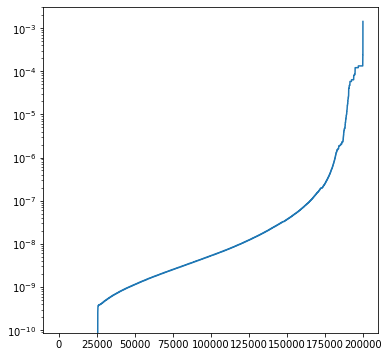

In [ ]:
freq_trg.sort()
plt.figure(figsize=(6,6))
plt.yscale('log')
plt.plot(freq_trg)

In [ ]:
#np.random.choice(4, p=[.1,.1,.4,.4],replace=True, size=10)
freq_src = np.array(freq_src)/sum(freq_src)
freq_trg = np.array(freq_trg)/sum(freq_trg)

In [ ]:
np.linalg.norm(s[0])

0.999999992172968

In [ ]:
eps = .00000001
s = s/(np.linalg.norm(s,axis=1)[:, np.newaxis]+eps)
t = t/(np.linalg.norm(t,axis=1)[:, np.newaxis]+eps)

In [ ]:
BATCH_SIZE = 1000
EPOCHS = 1000000
PRINT_EVERY_N_BATCHES = 10
N_CRITIC = 5
CLIP_THRESHOLD = 0.01
RUN_FOLDER = ''



In [ ]:
gan = WGAN(source_dim=300
         ,target_dim=300
         ,discriminator_dense_0=500
         ,discriminator_dense_1=128
         ,discriminator_dense_2=32
         ,freq_src= freq_src
         ,freq_trg=freq_trg)

In [ ]:
gan.train(     
    t
    ,s
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , clip_threshold = CLIP_THRESHOLD
)

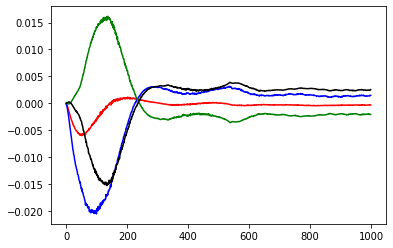

In [ ]:
d_l = np.array(gan.d_losses)
g_l = gan.g_losses
n,k = d_l.shape
plt.plot(range(n),d_l.T[0],color="r")
plt.plot(range(n),d_l.T[1],color="b")
plt.plot(range(n),d_l.T[2],color="g")
plt.plot(range(n),g_l,color="k")

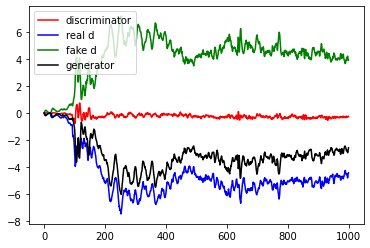

In [ ]:
d_l = np.array(gan.d_losses)
g_l = gan.g_losses
n,k = d_l.shape
d, = plt.plot(range(n),d_l.T[0],color="r")
r, = plt.plot(range(n),d_l.T[1],color="b")
f, = plt.plot(range(n),d_l.T[2],color="g")
g, = plt.plot(range(n),g_l,color="k")
plt.legend([d,r,f,g],['discriminator','real d','fake d','generator'])

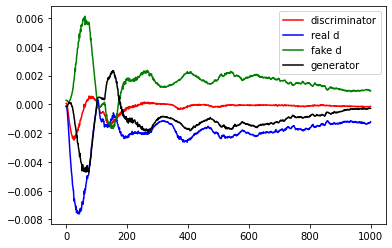

In [ ]:
d_l = np.array(gan.d_losses)
g_l = gan.g_losses
n,k = d_l.shape
d, = plt.plot(range(n),d_l.T[0],color="r")
r, = plt.plot(range(n),d_l.T[1],color="b")
f, = plt.plot(range(n),d_l.T[2],color="g")
g, = plt.plot(range(n),g_l,color="k")
plt.legend([d,r,f,g],['discriminator','real d','fake d','generator'])

In [ ]:
import collections
f = open('../S3/vecmap/data/dictionaries/en-it.test.txt', encoding='utf-8', errors='surrogateescape')
src2trg = collections.defaultdict(set)
oov = set()
vocab = set()
for line in f:
    src, trg = line.split()
    try:
        src_ind = src_word2ind[src]
        trg_ind = trg_word2ind[trg]
        src2trg[src_ind].add(trg_ind)
        vocab.add(src)
    except KeyError:
        oov.add(src)
src = list(src2trg.keys())


In [ ]:

ws = gan.generator(s)

In [ ]:
ws = ws.numpy()

In [ ]:
BATCH_Size = 500
translation = collections.defaultdict(int)
  # Standard nearest neighbor
for i in range(0, len(src), BATCH_Size):
    j = min(i + BATCH_Size, len(src))
    similarities = ws[src[i:j]].dot(t.T)
    nn = similarities.argmax(axis=1).tolist()
    for k in range(j-i):
        translation[src[i+k]] = nn[k]

In [ ]:
accuracy = np.mean([1 if translation[i] in src2trg[i] else 0 for i in src])
print(accuracy)

0.0


In [ ]:
for i in range( 100):
    print(ws[i].dot(t[list(src2trg[src[i]])[0]]))

<ipython-input-9-f127bff60a1f>:1: RuntimeWarning: invalid value encountered in true_divide
  x = x/np.linalg.norm(x,axis=1)[:, np.newaxis]


In [ ]:
np.linalg.norm(x[0])

1.0

In [ ]:
gan.train(     
    x
    ,z
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , clip_threshold = CLIP_THRESHOLD
)

In [ ]:
###############################################################################

In [ ]:
import cupy
def get_cupy():
    return cupy

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/drive/My Drive/MAP512WordEmbedding/en_10000_words_with_freq.csv')

In [ ]:
S = np.loadtxt('/content/drive/My Drive/MAP512WordEmbedding/en_vecs.csv',delimiter=',')
S = S[:5000]
xp = get_cupy()
S = np.asarray(S)

In [ ]:
from scipy.stats import ortho_group 

W = ortho_group.rvs(dim=300)
T = S@W

In [ ]:
f = df.FREQUENCY.iloc[:5000]
f /= sum(f)

In [ ]:
f = np.ones(5000)/5000
gan = WGAN(source_dim=300
         ,target_dim=300
         ,discriminator_dense_0=500
         ,discriminator_dense_1=128
         ,discriminator_dense_2=32
         ,freq_src= f
         ,freq_trg=f)

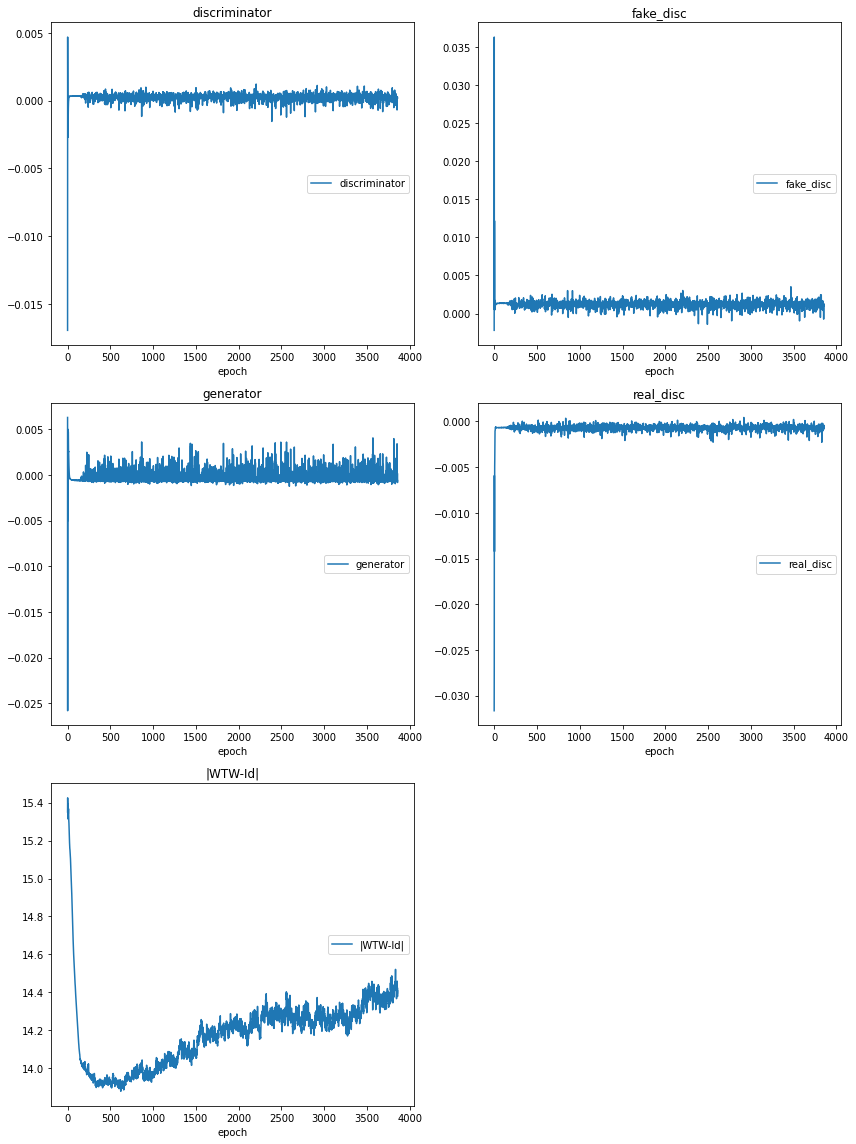

discriminator
	discriminator    	 (min:   -0.017, max:    0.005, cur:    0.000)
fake_disc
	fake_disc        	 (min:   -0.002, max:    0.036, cur:    0.001)
generator
	generator        	 (min:   -0.026, max:    0.006, cur:   -0.001)
real_disc
	real_disc        	 (min:   -0.032, max:    0.000, cur:   -0.001)
|WTW-Id|
	|WTW-Id|         	 (min:   13.879, max:   15.425, cur:   14.420)


In [ ]:
plotlosses = PlotLosses()
gan.train(     
    T
    ,S
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , clip_threshold = CLIP_THRESHOLD
)

In [ ]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

